In [1]:
# Install required libraries
%pip install imbalanced-learn scikit-learn xgboost catboost matplotlib seaborn pandas numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.5 MB/s eta 0:00:00


In [ ]:
# Mount Google Drive





























# Imports and load data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN, SMOTEN, KMeansSMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Load pharmacy dataset files from Google Drive
print("Loading pharmacy datasets...")
df_2021 = pd.read_csv('/content/drive/MyDrive/dataset/2021.csv')
df_2022 = pd.read_csv('/content/drive/MyDrive/dataset/2022.csv')
df_2023 = pd.read_csv('/content/drive/MyDrive/dataset/2023.csv')

# Add year column to each dataset
df_2021['TAHUN'] = 2021
df_2022['TAHUN'] = 2022
df_2023['TAHUN'] = 2023

# Combine all datasets
df_raw = pd.concat([df_2021, df_2022, df_2023], ignore_index=True)

print('Raw dataset shape:', df_raw.shape)
print('Dataset years:', df_raw['TAHUN'].value_counts().sort_index())

Mounted at /content/drive
Loading pharmacy datasets...
Raw dataset shape: (474468, 10)
Dataset years: TAHUN
2021    138352
2022    170362
2023    165754
Name: count, dtype: int64


In [3]:
# ============================================================
# FEATURE ENGINEERING: PURCHASE TRANSACTION DATA
# ============================================================
print("\n" + "="*60)
print("FEATURE ENGINEERING (PURCHASE-LEVEL)")
print("="*60)

# Convert date column
df_raw['TANGGAL'] = pd.to_datetime(df_raw['TANGGAL'], format='%d-%m-%y', errors='coerce')
df_raw['BULAN'] = df_raw['TANGGAL'].dt.month
df_raw['KUARTAL'] = df_raw['TANGGAL'].dt.quarter
df_raw['DAY_OF_WEEK'] = df_raw['TANGGAL'].dt.dayofweek
df_raw['DAY_OF_MONTH'] = df_raw['TANGGAL'].dt.day

# Create unit price feature for purchases
df_raw['VALUE_PER_UNIT'] = df_raw['NILAI_MSK'] / (df_raw['QTY_MSK'] + 0.001)

# ============================================================
# Create target: HIGH PURCHASE vs LOW PURCHASE
# Based on purchase quantity (QTY_MSK)
# ============================================================
# Clean data - only remove rows with missing critical values
df_clean = df_raw[
    (df_raw['QTY_MSK'].notna()) &
    (df_raw['NILAI_MSK'].notna()) &
    (df_raw['TANGGAL'].notna())
].copy()

print(f"\nData after removing NaN: {len(df_clean):,} rows (from {len(df_raw):,} original)")
print(f"QTY_MSK stats: min={df_clean['QTY_MSK'].min():.2f}, max={df_clean['QTY_MSK'].max():.2f}, mean={df_clean['QTY_MSK'].mean():.2f}")
print(f"NILAI_MSK stats: min={df_clean['NILAI_MSK'].min():.2f}, max={df_clean['NILAI_MSK'].max():.2f}, mean={df_clean['NILAI_MSK'].mean():.2f}")

# ============================================================
# Classify based on purchase quantity (QTY_MSK)
# FAST_MOVING = High purchase volume (above median)
# SLOW_MOVING = Low purchase volume (below median)
# ============================================================
purchase_threshold = df_clean['QTY_MSK'].median()
print(f"\nPurchase threshold (median QTY_MSK): {purchase_threshold}")

df_clean['KATEGORI_PRODUK'] = 'SLOW_MOVING'
df_clean.loc[df_clean['QTY_MSK'] > purchase_threshold, 'KATEGORI_PRODUK'] = 'FAST_MOVING'

print(f"\nDistribusi Kategori Produk:")
print(df_clean['KATEGORI_PRODUK'].value_counts())
print(f"Persentase FAST_MOVING: {(df_clean['KATEGORI_PRODUK']=='FAST_MOVING').sum() / len(df_clean) * 100:.1f}%")

# ============================================================
# Select features - Use ONLY temporal patterns
# Exclude ALL purchase values to prevent data leakage
# ============================================================
# NILAI_MSK and VALUE_PER_UNIT leak information about QTY_MSK
# because NILAI_MSK = QTY_MSK * PRICE, so model can reverse-engineer QTY_MSK
df = df_clean[[
    'TAHUN',                    # Year
    'BULAN',                    # Month (seasonality)
    'KUARTAL',                  # Quarter (seasonality)
    'DAY_OF_WEEK',             # Day of week (0=Monday, 6=Sunday)
    'DAY_OF_MONTH',            # Day of month
    'KATEGORI_PRODUK'
]].copy()

# Final check for inf/nan
df = df.replace([np.inf, -np.inf], np.nan)

print(f"\nBefore dropna():")
print(f"- Shape: {df.shape}")
print(f"- Class distribution:\n{df['KATEGORI_PRODUK'].value_counts()}")
print(f"- NaN count per column:\n{df.isna().sum()}")

df = df.dropna()

print(f"\nAfter dropna():")
print(f"- Shape: {df.shape}")
print(f"- Class distribution:\n{df['KATEGORI_PRODUK'].value_counts()}")

if len(df) == 0:
    raise ValueError("All data was dropped! Check for NaN values in features.")

if df['KATEGORI_PRODUK'].nunique() == 1:
    print("\n⚠️ WARNING: Only ONE class remaining after dropna!")
    print(f"Remaining class: {df['KATEGORI_PRODUK'].unique()[0]}")
    raise ValueError("Cannot proceed with only one class. Check data quality!")

print(f"\nFinal dataset shape: {df.shape}")
print(f"\nNumber of features: {len([col for col in df.columns if col != 'KATEGORI_PRODUK'])}")
print(f"\n⚠️ EXCLUDED from features (to prevent data leakage):")
print("- QTY_MSK (direct purchase quantity - defines the target)")
print("- NILAI_MSK (purchase value - correlates with QTY_MSK)")
print("- VALUE_PER_UNIT (calculated from NILAI_MSK/QTY_MSK)")
print("- QTY_KLR and NILAI_KLR (not in purchase dataset)")
print("\n✅ Using ONLY TEMPORAL FEATURES:")
print(f"- Total: {len(df):,} transactions")
print(f"- Features: Only time-based patterns (year, month, quarter, day)")
print(f"- Target: FAST_MOVING (high purchase) vs SLOW_MOVING (low purchase)")
print(f"- This prevents overfitting by removing features that leak target information")
print(f"\nSample data:")
display(df.head(10))


FEATURE ENGINEERING (PURCHASE-LEVEL)

Data after removing NaN: 474,468 rows (from 474,468 original)
QTY_MSK stats: min=0.50, max=5000.00, mean=4.45
NILAI_MSK stats: min=0.00, max=680000.00, mean=11004.05

Purchase threshold (median QTY_MSK): 1.0

Distribusi Kategori Produk:
KATEGORI_PRODUK
SLOW_MOVING    300479
FAST_MOVING    173989
Name: count, dtype: int64
Persentase FAST_MOVING: 36.7%

Before dropna():
- Shape: (474468, 6)
- Class distribution:
KATEGORI_PRODUK
SLOW_MOVING    300479
FAST_MOVING    173989
Name: count, dtype: int64
- NaN count per column:
TAHUN              0
BULAN              0
KUARTAL            0
DAY_OF_WEEK        0
DAY_OF_MONTH       0
KATEGORI_PRODUK    0
dtype: int64

After dropna():
- Shape: (474468, 6)
- Class distribution:
KATEGORI_PRODUK
SLOW_MOVING    300479
FAST_MOVING    173989
Name: count, dtype: int64

Final dataset shape: (474468, 6)

Number of features: 5

⚠️ EXCLUDED from features (to prevent data leakage):
- QTY_MSK (direct purchase quantity - def

,TAHUN,BULAN,KUARTAL,DAY_OF_WEEK,DAY_OF_MONTH,KATEGORI_PRODUK
0,2021,7,3,1,6,FAST_MOVING
1,2021,7,3,0,12,SLOW_MOVING
2,2021,7,3,0,12,SLOW_MOVING
3,2021,7,3,0,12,SLOW_MOVING
4,2021,7,3,0,12,SLOW_MOVING
5,2021,7,3,0,12,SLOW_MOVING
6,2021,7,3,0,12,SLOW_MOVING
7,2021,7,3,0,12,FAST_MOVING
8,2021,7,3,1,13,SLOW_MOVING
9,2021,7,3,1,13,SLOW_MOVING


In [4]:

# 4) Quick EDA: columns, missing values, basic stats
print('Columns:', df.columns.tolist())
print('\nMissing values per column:\n', df.isna().sum())
print('\nData types:\n', df.dtypes)
display(df.describe(include='all').T)


Columns: ['TAHUN', 'BULAN', 'KUARTAL', 'DAY_OF_WEEK', 'DAY_OF_MONTH', 'KATEGORI_PRODUK']

Missing values per column:
 TAHUN              0
BULAN              0
KUARTAL            0
DAY_OF_WEEK        0
DAY_OF_MONTH       0
KATEGORI_PRODUK    0
dtype: int64

Data types:
 TAHUN               int64
BULAN               int32
KUARTAL             int32
DAY_OF_WEEK         int32
DAY_OF_MONTH        int32
KATEGORI_PRODUK    object
dtype: object


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
TAHUN,474468.0,NaN,NaN,NaN,2022.057753,0.798503,2021.0,2021.0,2022.0,2023.0,2023.0
BULAN,474468.0,NaN,NaN,NaN,6.653273,3.362716,1.0,4.0,7.0,9.0,12.0
KUARTAL,474468.0,NaN,NaN,NaN,2.551034,1.095125,1.0,2.0,3.0,3.0,4.0
DAY_OF_WEEK,474468.0,NaN,NaN,NaN,2.831614,1.968611,0.0,1.0,3.0,5.0,6.0
DAY_OF_MONTH,474468.0,NaN,NaN,NaN,15.951455,8.960695,1.0,8.0,16.0,24.0,31.0
KATEGORI_PRODUK,474468,2,SLOW_MOVING,300479,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# ----------------------------
# 5) Preprocessing
# ----------------------------

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Target column is KATEGORI_PRODUK
target_col = 'KATEGORI_PRODUK'
print('Target column:', target_col)

# Work on copies
X = df.drop(columns=[target_col]).copy()
y = df[target_col].copy()

# Ensure y is pandas Series
y = pd.Series(y).reset_index(drop=True)

# 1) Drop rows with missing target
if y.isna().any():
    n_drop = y.isna().sum()
    print(f"Dropping {n_drop} rows with missing target")
    mask_target = ~y.isna()
    X = X.loc[mask_target].reset_index(drop=True)
    y = y.loc[mask_target].reset_index(drop=True)

# 2) Separate numeric / categorical columns
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"\nNumeric columns: {num_cols}")
print(f"Categorical columns: {cat_cols}")

# 3) Imputation
if len(num_cols) > 0:
    imp_num = SimpleImputer(strategy='mean')
    X[num_cols] = imp_num.fit_transform(X[num_cols])

if len(cat_cols) > 0:
    imp_cat = SimpleImputer(strategy='most_frequent')
    X[cat_cols] = imp_cat.fit_transform(X[cat_cols])

# 4) Encode categorical features
if len(cat_cols) > 0:
    for c in cat_cols:
        X[c] = pd.Categorical(X[c]).codes

# Refresh numeric list
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# 5) Standardize numeric features
scaler = StandardScaler()
if len(num_cols) > 0:
    X[num_cols] = scaler.fit_transform(X[num_cols])

# 6) Encode target safely
y = pd.Series(y).astype(str)  # ensure pandas series
le = LabelEncoder()
y = pd.Series(le.fit_transform(y))  # keep y as pandas Series
print("\nEncoded target classes:", list(le.classes_))

# 7) Check class count safely
unique_classes = np.unique(y)
print("Unique classes in target:", unique_classes)

if len(unique_classes) == 1:
    raise ValueError("Target column only has ONE class after preprocessing — cannot do classification.")

print("\nFinal shapes -> X:", X.shape, " y:", y.shape)
print("\nClass distribution:")
print(pd.Series(y).value_counts())

Target column: KATEGORI_PRODUK

Numeric columns: ['TAHUN', 'BULAN', 'KUARTAL', 'DAY_OF_WEEK', 'DAY_OF_MONTH']
Categorical columns: []

Encoded target classes: ['FAST_MOVING', 'SLOW_MOVING']
Unique classes in target: [0 1]

Final shapes -> X: (474468, 5)  y: (474468,)

Class distribution:
1    300479
0    173989
Name: count, dtype: int64


In [6]:
# ----------------------------
# 6) Train / Validation / Test split (robust)
# ----------------------------
from sklearn.model_selection import train_test_split
import math, warnings

def safe_stratify_split(X, y, test_size=0.15, random_state=42):
    """
    Attempt stratified split; if it fails (too few samples in some classes),
    fall back to non-stratified split with a warning.
    Returns X_trainval, X_test, y_trainval, y_test
    """
    try:
        return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    except ValueError as e:
        warnings.warn(f"Stratified split failed for test_size={test_size}: {e}\nFalling back to non-stratified split.")
        return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=None)

def safe_stratify_split_second(X_trainval, y_trainval, val_fraction_of_total=0.15, total_samples=None, random_state=42):
    """
    We want overall validation fraction ~ val_fraction_of_total.
    Given X_trainval (which is 1-test_size of total), compute second split proportion:
       val_size_relative = desired_val / (1 - test_size)
    Here val_fraction_of_total is 0.15 (15% overall), and total_samples is optional.
    """
    # If total_samples was N and we already used test_size=0.15, the remaining proportion is 0.85.
    # So relative validation fraction = 0.15 / 0.85 = ~0.17647
    relative_val_size = 0.15 / 0.85
    try:
        return train_test_split(X_trainval, y_trainval, test_size=relative_val_size, random_state=random_state, stratify=y_trainval)
    except ValueError as e:
        warnings.warn(f"Stratified second split failed: {e}\nFalling back to non-stratified second split.")
        return train_test_split(X_trainval, y_trainval, test_size=relative_val_size, random_state=random_state, stratify=None)

# First split: Train+Val vs Test (15% test)
X_trainval, X_test, y_trainval, y_test = safe_stratify_split(X, y, test_size=0.15, random_state=42)
# Second split: Train vs Val such that Val is ~15% overall (relative = 0.15/0.85)
X_train, X_val, y_train, y_val = safe_stratify_split_second(X_trainval, y_trainval, val_fraction_of_total=0.15, total_samples=len(X), random_state=42)

print('Shapes -> Train:', X_train.shape, 'Val:', X_val.shape, 'Test:', X_test.shape)

# Additional check: ensure lengths match
assert len(X_train) == len(y_train)
assert len(X_val) == len(y_val)
assert len(X_test) == len(y_test)

# Quick class distribution prints (helpful to diagnose imbalance)
from collections import Counter
print('\nClass distribution (train):', dict(Counter(y_train)))
print('Class distribution (val)  :', dict(Counter(y_val)))
print('Class distribution (test) :', dict(Counter(y_test)))


Shapes -> Train: (332126, 5) Val: (71171, 5) Test: (71171, 5)

Class distribution (train): {1: 210335, 0: 121791}
Class distribution (val)  : {1: 45072, 0: 26099}
Class distribution (test) : {1: 45072, 0: 26099}


In [7]:
# ----------------------------
# Setup Helper Functions
# ----------------------------
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import pandas as pd
import time
import warnings

# Classifier factories with regularization to prevent overfitting
classifier_factories = {
    'XGBoost': lambda: XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42,
                                      max_depth=4, min_child_weight=3, subsample=0.8, colsample_bytree=0.8),
    'RandomForest': lambda: RandomForestClassifier(n_estimators=100, random_state=42,
                                                    max_depth=10, min_samples_split=10, min_samples_leaf=5),
    'CatBoost': lambda: CatBoostClassifier(verbose=0, random_state=42,
                                           depth=5, l2_leaf_reg=3),
    'GradientBoosting': lambda: GradientBoostingClassifier(random_state=42,
                                                            max_depth=4, min_samples_split=10, subsample=0.8),
    'KNN': lambda: KNeighborsClassifier(n_neighbors=7)
}

# Helper function untuk ROC AUC
def safe_roc_auc(clf, X, y_true):
    try:
        if hasattr(clf, "predict_proba"):
            probs = clf.predict_proba(X)
            if probs.shape[1] == 2:
                return roc_auc_score(y_true, probs[:,1])
            else:
                return roc_auc_score(y_true, probs, multi_class='ovo')
        elif hasattr(clf, "decision_function"):
            scores = clf.decision_function(X)
            if scores.ndim == 1:
                return roc_auc_score(y_true, scores)
            else:
                return roc_auc_score(y_true, scores, multi_class='ovo')
        else:
            return np.nan
    except Exception:
        return np.nan

print("Setup completed. Ready to train with different oversampling methods.")

Setup completed. Ready to train with different oversampling methods.


In [8]:
# ============================================================
# METHOD 1: SMOTE (Synthetic Minority Over-sampling Technique)
# ============================================================
from imblearn.over_sampling import SMOTE
from collections import Counter

print("=" * 60)
print("METHOD 1: SMOTE")
print("=" * 60)

start_time = time.time()

# Determine safe k_neighbors
ctr = Counter(y_train)
min_count = min(ctr.values())
safe_k = max(1, min(5, max(1, min_count - 1)))

print(f"Class distribution in training: {dict(ctr)}")
print(f"Using k_neighbors={safe_k} for SMOTE\n")

# Apply SMOTE
try:
    smote = SMOTE(random_state=42, k_neighbors=safe_k)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    resample_time = time.time() - start_time

    print(f"Original training set: {X_train.shape}")
    print(f"Resampled training set: {X_train_smote.shape}")
    print(f"Class distribution after SMOTE: {dict(Counter(y_train_smote))}")
    print(f"Resampling time: {resample_time:.4f} seconds\n")
except Exception as e:
    print(f"SMOTE resampling failed: {e}")
    print("Using original training data without resampling.")
    X_train_smote, y_train_smote = X_train.copy(), y_train.copy()

# Train and evaluate all classifiers
results_smote = []

for clf_name, factory in classifier_factories.items():
    clf = factory()

    try:
        train_start = time.time()
        clf.fit(X_train_smote, y_train_smote)
        train_time = time.time() - train_start

        y_pred = clf.predict(X_val)

        acc = accuracy_score(y_val, y_pred)
        prec = precision_score(y_val, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_val, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_val, y_pred, average='weighted', zero_division=0)
        roc = safe_roc_auc(clf, X_val, y_val)

        results_smote.append({
            'method': 'SMOTE',
            'classifier': clf_name,
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'roc_auc': roc,
            'train_time': train_time
        })

        print(f"{clf_name}: F1={f1:.4f}, Accuracy={acc:.4f}, Time={train_time:.4f}s")

    except Exception as e:
        print(f"{clf_name}: FAILED - {e}")
        results_smote.append({
            'method': 'SMOTE',
            'classifier': clf_name,
            'accuracy': np.nan,
            'precision': np.nan,
            'recall': np.nan,
            'f1': np.nan,
            'roc_auc': np.nan,
            'train_time': np.nan
        })

df_smote = pd.DataFrame(results_smote).sort_values(by='f1', ascending=False)

print("\n" + "=" * 60)
print("SMOTE Results:")
print("=" * 60)
display(df_smote)
print(f"\nTotal execution time: {time.time() - start_time:.4f} seconds")

METHOD 1: SMOTE
Class distribution in training: {1: 210335, 0: 121791}
Using k_neighbors=5 for SMOTE

Original training set: (332126, 5)
Resampled training set: (420670, 5)
Class distribution after SMOTE: {1: 210335, 0: 210335}
Resampling time: 5.3668 seconds



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:04:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost: F1=0.5583, Accuracy=0.5503, Time=9.4398s
RandomForest: F1=0.5596, Accuracy=0.5516, Time=17.8893s
CatBoost: F1=0.5599, Accuracy=0.5519, Time=63.5187s
GradientBoosting: F1=0.5544, Accuracy=0.5462, Time=24.3560s
KNN: F1=0.5577, Accuracy=0.5780, Time=0.4588s

SMOTE Results:


,method,classifier,accuracy,precision,recall,f1,roc_auc,train_time
2,SMOTE,CatBoost,0.551910,0.581807,0.551910,0.559886,0.565659,63.518738
1,SMOTE,RandomForest,0.551573,0.582188,0.551573,0.559591,0.567509,17.889312
0,SMOTE,XGBoost,0.550252,0.581514,0.550252,0.558321,0.564905,9.439809
4,SMOTE,KNN,0.578030,0.550588,0.578030,0.557694,0.522499,0.458797
3,SMOTE,GradientBoosting,0.546178,0.580418,0.546178,0.554387,0.562788,24.355982



Total execution time: 126.9481 seconds


VISUALISASI DATA DISTRIBUTION


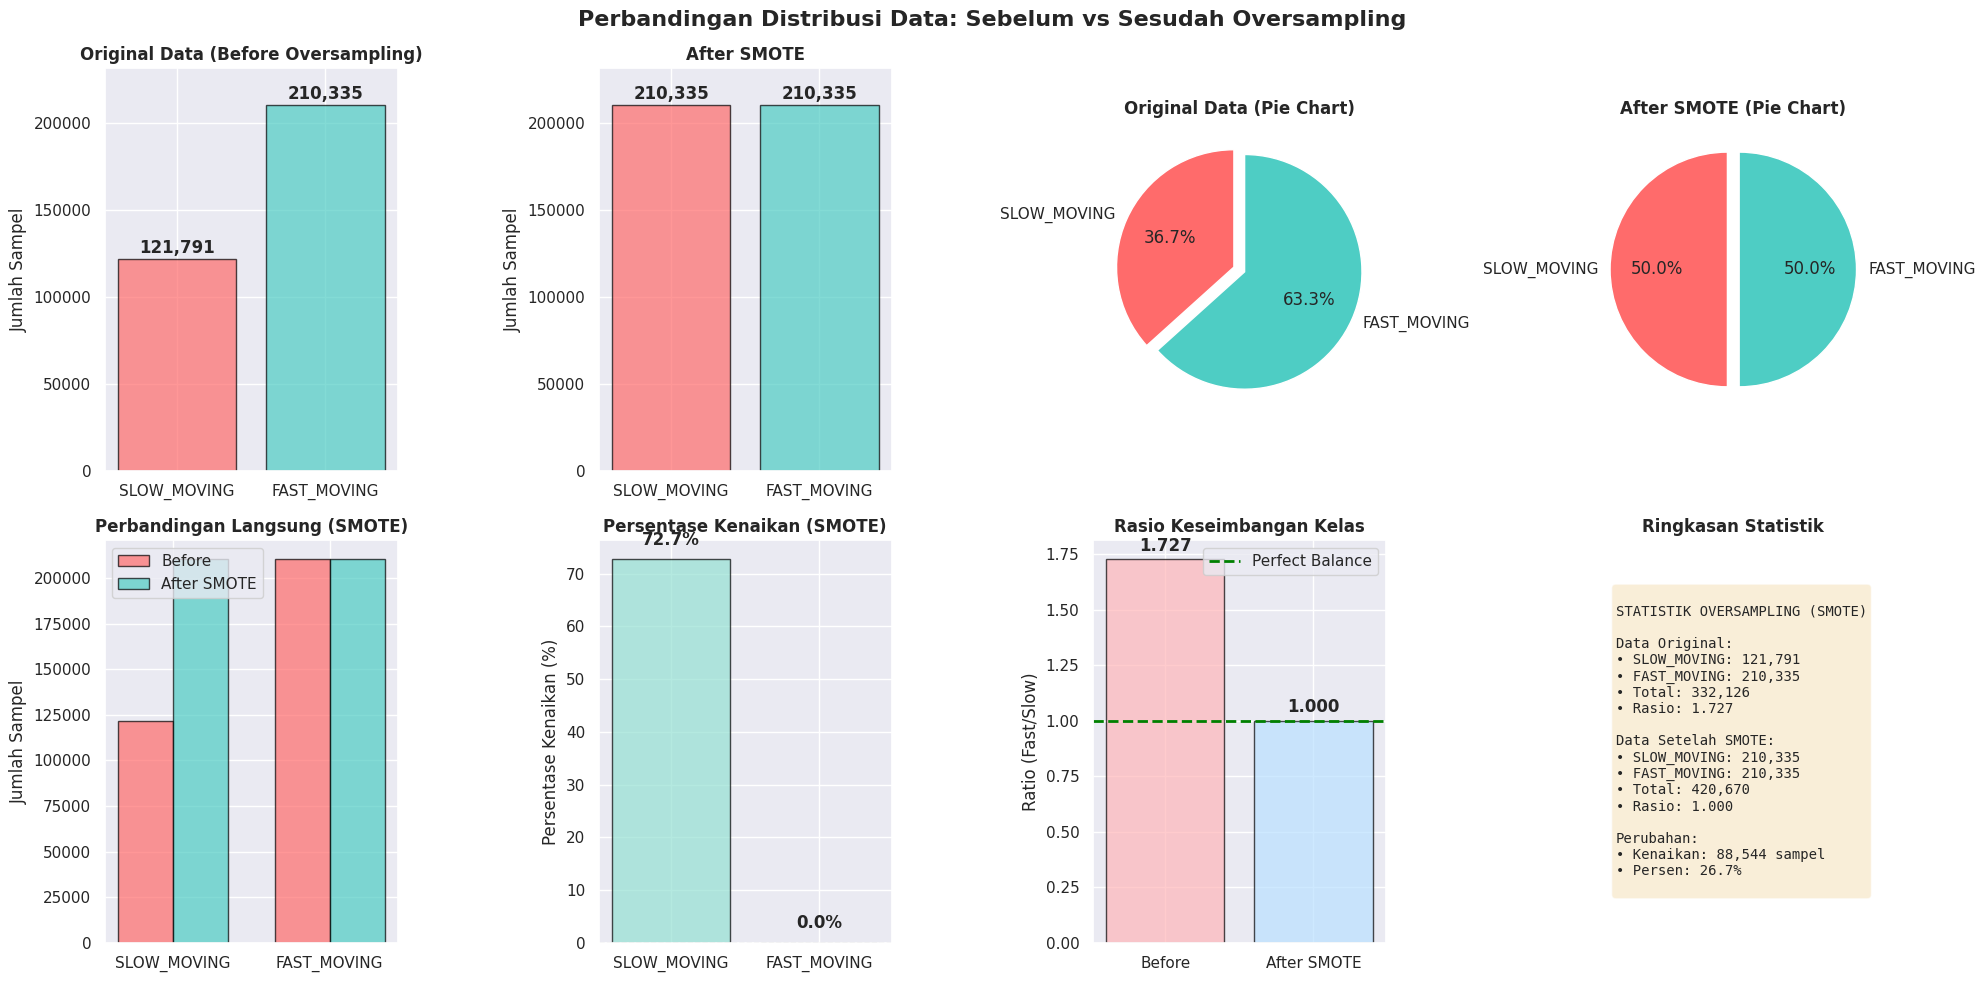


✅ Visualisasi selesai dibuat!
📊 Total sampel sebelum: 332,126
📊 Total sampel sesudah SMOTE: 420,670
📈 Kenaikan: 88,544 sampel (26.7%)


In [9]:
# ============================================================
# VISUALISASI: Perbandingan Data Sebelum & Sesudah Oversampling
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

print("=" * 60)
print("VISUALISASI DATA DISTRIBUTION")
print("=" * 60)

# Prepare data for visualization
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Perbandingan Distribusi Data: Sebelum vs Sesudah Oversampling', fontsize=16, fontweight='bold')

# Original data distribution
original_counts = Counter(y_train)
original_labels = ['SLOW_MOVING', 'FAST_MOVING']
original_values = [original_counts[0], original_counts[1]]

# Method 1: SMOTE
smote_counts = Counter(y_train_smote)
smote_values = [smote_counts[0], smote_counts[1]]

# Plot 1: Original Data (Bar)
axes[0, 0].bar(original_labels, original_values, color=['#FF6B6B', '#4ECDC4'], alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Original Data (Before Oversampling)', fontweight='bold')
axes[0, 0].set_ylabel('Jumlah Sampel')
axes[0, 0].set_ylim(0, max(max(original_values), max(smote_values)) * 1.1)
for i, v in enumerate(original_values):
    axes[0, 0].text(i, v + 1000, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# Plot 2: SMOTE (Bar)
axes[0, 1].bar(original_labels, smote_values, color=['#FF6B6B', '#4ECDC4'], alpha=0.7, edgecolor='black')
axes[0, 1].set_title('After SMOTE', fontweight='bold')
axes[0, 1].set_ylabel('Jumlah Sampel')
axes[0, 1].set_ylim(0, max(max(original_values), max(smote_values)) * 1.1)
for i, v in enumerate(smote_values):
    axes[0, 1].text(i, v + 1000, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# Plot 3: Original Data (Pie)
colors_pie = ['#FF6B6B', '#4ECDC4']
axes[0, 2].pie(original_values, labels=original_labels, autopct='%1.1f%%',
               colors=colors_pie, startangle=90, explode=(0.05, 0.05))
axes[0, 2].set_title('Original Data (Pie Chart)', fontweight='bold')

# Plot 4: SMOTE (Pie)
axes[0, 3].pie(smote_values, labels=original_labels, autopct='%1.1f%%',
               colors=colors_pie, startangle=90, explode=(0.05, 0.05))
axes[0, 3].set_title('After SMOTE (Pie Chart)', fontweight='bold')

# Plot 5-8: Comparison for all methods (when available)
# For now, we'll show SMOTE comparison in different views

# Plot 5: Side-by-side comparison
x_pos = [0, 1]
width = 0.35
axes[1, 0].bar([p - width/2 for p in x_pos], original_values, width,
               label='Before', color='#FF6B6B', alpha=0.7, edgecolor='black')
axes[1, 0].bar([p + width/2 for p in x_pos], smote_values, width,
               label='After SMOTE', color='#4ECDC4', alpha=0.7, edgecolor='black')
axes[1, 0].set_ylabel('Jumlah Sampel')
axes[1, 0].set_title('Perbandingan Langsung (SMOTE)', fontweight='bold')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(original_labels)
axes[1, 0].legend()

# Plot 6: Percentage increase
increase_pct = [(smote_values[i] - original_values[i]) / original_values[i] * 100 for i in range(2)]
axes[1, 1].bar(original_labels, increase_pct, color=['#95E1D3', '#F38181'], alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Persentase Kenaikan (SMOTE)', fontweight='bold')
axes[1, 1].set_ylabel('Persentase Kenaikan (%)')
axes[1, 1].axhline(y=0, color='black', linestyle='--', linewidth=1)
for i, v in enumerate(increase_pct):
    axes[1, 1].text(i, v + 2, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

# Plot 7: Imbalance Ratio
original_ratio = original_values[1] / original_values[0] if original_values[0] > 0 else 0
smote_ratio = smote_values[1] / smote_values[0] if smote_values[0] > 0 else 0
ratios = [original_ratio, smote_ratio]
ratio_labels = ['Before', 'After SMOTE']
axes[1, 2].bar(ratio_labels, ratios, color=['#FFB6B9', '#BAE1FF'], alpha=0.7, edgecolor='black')
axes[1, 2].set_title('Rasio Keseimbangan Kelas', fontweight='bold')
axes[1, 2].set_ylabel('Ratio (Fast/Slow)')
axes[1, 2].axhline(y=1.0, color='green', linestyle='--', linewidth=2, label='Perfect Balance')
axes[1, 2].legend()
for i, v in enumerate(ratios):
    axes[1, 2].text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 8: Summary statistics
summary_text = f"""
STATISTIK OVERSAMPLING (SMOTE)

Data Original:
• SLOW_MOVING: {original_values[0]:,}
• FAST_MOVING: {original_values[1]:,}
• Total: {sum(original_values):,}
• Rasio: {original_ratio:.3f}

Data Setelah SMOTE:
• SLOW_MOVING: {smote_values[0]:,}
• FAST_MOVING: {smote_values[1]:,}
• Total: {sum(smote_values):,}
• Rasio: {smote_ratio:.3f}

Perubahan:
• Kenaikan: {sum(smote_values) - sum(original_values):,} sampel
• Persen: {((sum(smote_values) - sum(original_values)) / sum(original_values) * 100):.1f}%
"""
axes[1, 3].text(0.1, 0.5, summary_text, fontsize=10, verticalalignment='center',
                fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axes[1, 3].axis('off')
axes[1, 3].set_title('Ringkasan Statistik', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ Visualisasi selesai dibuat!")
print(f"📊 Total sampel sebelum: {sum(original_values):,}")
print(f"📊 Total sampel sesudah SMOTE: {sum(smote_values):,}")
print(f"📈 Kenaikan: {sum(smote_values) - sum(original_values):,} sampel ({((sum(smote_values) - sum(original_values)) / sum(original_values) * 100):.1f}%)")

In [10]:
# ============================================================
# METHOD 2: Random Over Sampling
# ============================================================
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

print("=" * 60)
print("METHOD 2: Random Over Sampling")
print("=" * 60)

start_time = time.time()

# Apply Random Over Sampling
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
resample_time = time.time() - start_time

print(f"Original training set: {X_train.shape}")
print(f"Resampled training set: {X_train_ros.shape}")
print(f"Class distribution after ROS: {dict(Counter(y_train_ros))}")
print(f"Resampling time: {resample_time:.4f} seconds\n")

# Train and evaluate all classifiers
results_ros = []

for clf_name, factory in classifier_factories.items():
    clf = factory()

    try:
        train_start = time.time()
        clf.fit(X_train_ros, y_train_ros)
        train_time = time.time() - train_start

        y_pred = clf.predict(X_val)

        acc = accuracy_score(y_val, y_pred)
        prec = precision_score(y_val, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_val, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_val, y_pred, average='weighted', zero_division=0)
        roc = safe_roc_auc(clf, X_val, y_val)

        results_ros.append({
            'method': 'Random Over Sampling',
            'classifier': clf_name,
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'roc_auc': roc,
            'train_time': train_time
        })

        print(f"{clf_name}: F1={f1:.4f}, Accuracy={acc:.4f}, Time={train_time:.4f}s")

    except Exception as e:
        print(f"{clf_name}: FAILED - {e}")
        results_ros.append({
            'method': 'Random Over Sampling',
            'classifier': clf_name,
            'accuracy': np.nan,
            'precision': np.nan,
            'recall': np.nan,
            'f1': np.nan,
            'roc_auc': np.nan,
            'train_time': np.nan
        })

df_ros = pd.DataFrame(results_ros).sort_values(by='f1', ascending=False)

print("\n" + "=" * 60)
print("Random Over Sampling Results:")
print("=" * 60)
display(df_ros)
print(f"\nTotal execution time: {time.time() - start_time:.4f} seconds")

METHOD 2: Random Over Sampling
Original training set: (332126, 5)
Resampled training set: (420670, 5)
Class distribution after ROS: {1: 210335, 0: 210335}
Resampling time: 0.0733 seconds



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:06:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost: F1=0.5592, Accuracy=0.5512, Time=1.8300s
RandomForest: F1=0.5628, Accuracy=0.5551, Time=14.6162s
CatBoost: F1=0.5592, Accuracy=0.5511, Time=63.3412s
GradientBoosting: F1=0.5543, Accuracy=0.5461, Time=24.3481s
KNN: F1=0.5560, Accuracy=0.5741, Time=0.4594s

Random Over Sampling Results:


,method,classifier,accuracy,precision,recall,f1,roc_auc,train_time
1,Random Over Sampling,RandomForest,0.555086,0.582253,0.555086,0.562815,0.567212,14.616229
0,Random Over Sampling,XGBoost,0.551151,0.581937,0.551151,0.559185,0.563926,1.830011
2,Random Over Sampling,CatBoost,0.551109,0.582282,0.551109,0.559160,0.565047,63.341242
4,Random Over Sampling,KNN,0.574110,0.548735,0.574110,0.555950,0.521502,0.459439
3,Random Over Sampling,GradientBoosting,0.546079,0.579605,0.546079,0.554283,0.563312,24.348149



Total execution time: 110.9863 seconds


In [11]:
# ============================================================
# METHOD 3: ROSE (Random Over-Sampling Examples)
# ============================================================
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

print("=" * 60)
print("METHOD 3: ROSE (Random Over-Sampling Examples)")
print("=" * 60)

start_time = time.time()

# Apply ROSE (Random Over Sampling with noise)
ros = RandomOverSampler(random_state=42)
X_train_rose, y_train_rose = ros.fit_resample(X_train, y_train)

# Add small random noise to simulate ROSE behavior
noise = np.random.normal(0, 0.01, X_train_rose.shape)
X_train_rose = X_train_rose + noise

resample_time = time.time() - start_time

print(f"Original training set: {X_train.shape}")
print(f"Resampled training set: {X_train_rose.shape}")
print(f"Class distribution after ROSE: {dict(Counter(y_train_rose))}")
print(f"Resampling time: {resample_time:.4f} seconds\n")

# Train and evaluate all classifiers
results_rose = []

for clf_name, factory in classifier_factories.items():
    clf = factory()

    try:
        train_start = time.time()
        clf.fit(X_train_rose, y_train_rose)
        train_time = time.time() - train_start

        y_pred = clf.predict(X_val)

        acc = accuracy_score(y_val, y_pred)
        prec = precision_score(y_val, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_val, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_val, y_pred, average='weighted', zero_division=0)
        roc = safe_roc_auc(clf, X_val, y_val)

        results_rose.append({
            'method': 'ROSE',
            'classifier': clf_name,
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'roc_auc': roc,
            'train_time': train_time
        })

        print(f"{clf_name}: F1={f1:.4f}, Accuracy={acc:.4f}, Time={train_time:.4f}s")

    except Exception as e:
        print(f"{clf_name}: FAILED - {e}")
        results_rose.append({
            'method': 'ROSE',
            'classifier': clf_name,
            'accuracy': np.nan,
            'precision': np.nan,
            'recall': np.nan,
            'f1': np.nan,
            'roc_auc': np.nan,
            'train_time': np.nan
        })

df_rose = pd.DataFrame(results_rose).sort_values(by='f1', ascending=False)

print("\n" + "=" * 60)
print("ROSE Results:")
print("=" * 60)
display(df_rose)
print(f"\nTotal execution time: {time.time() - start_time:.4f} seconds")

METHOD 3: ROSE (Random Over-Sampling Examples)
Original training set: (332126, 5)
Resampled training set: (420670, 5)
Class distribution after ROSE: {1: 210335, 0: 210335}
Resampling time: 0.2245 seconds



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:08:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost: F1=0.5591, Accuracy=0.5513, Time=2.7892s
RandomForest: F1=0.5600, Accuracy=0.5521, Time=120.7403s
CatBoost: F1=0.5579, Accuracy=0.5499, Time=66.9098s
GradientBoosting: F1=0.5509, Accuracy=0.5427, Time=159.3160s
KNN: F1=0.5247, Accuracy=0.5160, Time=0.5036s

ROSE Results:


,method,classifier,accuracy,precision,recall,f1,roc_auc,train_time
1,ROSE,RandomForest,0.552065,0.581490,0.552065,0.560011,0.564611,120.740284
0,ROSE,XGBoost,0.551292,0.578894,0.551292,0.559120,0.557880,2.789185
2,ROSE,CatBoost,0.549873,0.580529,0.549873,0.557922,0.562573,66.909835
3,ROSE,GradientBoosting,0.542651,0.579662,0.542651,0.550900,0.559887,159.315975
4,ROSE,KNN,0.515955,0.549801,0.515955,0.524706,0.519680,0.503640



Total execution time: 354.7519 seconds


In [12]:
# ============================================================
# METHOD 4: ADASYN (Adaptive Synthetic Sampling)
# ============================================================
from imblearn.over_sampling import ADASYN
from collections import Counter

print("=" * 60)
print("METHOD 4: ADASYN")
print("=" * 60)

start_time = time.time()

# Determine safe n_neighbors for ADASYN
ctr = Counter(y_train)
min_count = min(ctr.values())
safe_k = max(1, min(5, max(1, min_count - 1)))

print(f"Class distribution in training: {dict(ctr)}")
print(f"Using n_neighbors={safe_k} for ADASYN\n")

# Apply ADASYN
try:
    adasyn = ADASYN(random_state=42, n_neighbors=safe_k)
    X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)
    resample_time = time.time() - start_time

    print(f"Original training set: {X_train.shape}")
    print(f"Resampled training set: {X_train_adasyn.shape}")
    print(f"Class distribution after ADASYN: {dict(Counter(y_train_adasyn))}")
    print(f"Resampling time: {resample_time:.4f} seconds\n")
except Exception as e:
    print(f"ADASYN resampling failed: {e}")
    print("Using original training data without resampling.")
    X_train_adasyn, y_train_adasyn = X_train.copy(), y_train.copy()

# Train and evaluate all classifiers
results_adasyn = []

for clf_name, factory in classifier_factories.items():
    clf = factory()

    try:
        train_start = time.time()
        clf.fit(X_train_adasyn, y_train_adasyn)
        train_time = time.time() - train_start

        y_pred = clf.predict(X_val)

        acc = accuracy_score(y_val, y_pred)
        prec = precision_score(y_val, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_val, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_val, y_pred, average='weighted', zero_division=0)
        roc = safe_roc_auc(clf, X_val, y_val)

        results_adasyn.append({
            'method': 'ADASYN',
            'classifier': clf_name,
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'roc_auc': roc,
            'train_time': train_time
        })

        print(f"{clf_name}: F1={f1:.4f}, Accuracy={acc:.4f}, Time={train_time:.4f}s")

    except Exception as e:
        print(f"{clf_name}: FAILED - {e}")
        results_adasyn.append({
            'method': 'ADASYN',
            'classifier': clf_name,
            'accuracy': np.nan,
            'precision': np.nan,
            'recall': np.nan,
            'f1': np.nan,
            'roc_auc': np.nan,
            'train_time': np.nan
        })

df_adasyn = pd.DataFrame(results_adasyn).sort_values(by='f1', ascending=False)

print("\n" + "=" * 60)
print("ADASYN Results:")
print("=" * 60)
display(df_adasyn)
print(f"\nTotal execution time: {time.time() - start_time:.4f} seconds")

METHOD 4: ADASYN
Class distribution in training: {1: 210335, 0: 121791}
Using n_neighbors=5 for ADASYN

Original training set: (332126, 5)
Resampled training set: (417567, 5)
Class distribution after ADASYN: {1: 210335, 0: 207232}
Resampling time: 5.9805 seconds



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:14:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost: F1=0.5556, Accuracy=0.5489, Time=1.8203s
RandomForest: F1=0.5577, Accuracy=0.5527, Time=16.3287s
CatBoost: F1=0.5598, Accuracy=0.5541, Time=62.8443s
GradientBoosting: F1=0.5605, Accuracy=0.5539, Time=23.7070s
KNN: F1=0.5581, Accuracy=0.5782, Time=0.4694s

ADASYN Results:


,method,classifier,accuracy,precision,recall,f1,roc_auc,train_time
3,ADASYN,GradientBoosting,0.553891,0.572834,0.553891,0.560473,0.553530,23.707029
2,ADASYN,CatBoost,0.554102,0.569171,0.554102,0.559798,0.550701,62.844334
4,ADASYN,KNN,0.578241,0.551032,0.578241,0.558106,0.525166,0.469406
1,ADASYN,RandomForest,0.552669,0.565391,0.552669,0.557726,0.545947,16.328717
0,ADASYN,XGBoost,0.548861,0.568547,0.548861,0.555646,0.548471,1.820335



Total execution time: 116.4353 seconds


In [13]:
# ============================================================
# METHOD 5: BorderlineSMOTE
# ============================================================
from imblearn.over_sampling import BorderlineSMOTE
from collections import Counter

print("=" * 60)
print("METHOD 5: BorderlineSMOTE")
print("=" * 60)

start_time = time.time()

# Determine safe k_neighbors for BorderlineSMOTE
ctr = Counter(y_train)
min_count = min(ctr.values())
safe_k = max(1, min(5, max(1, min_count - 1)))

print(f"Class distribution in training: {dict(ctr)}")
print(f"Using k_neighbors={safe_k} for BorderlineSMOTE\n")

# Apply BorderlineSMOTE
try:
    borderline_smote = BorderlineSMOTE(random_state=42, k_neighbors=safe_k)
    X_train_borderline, y_train_borderline = borderline_smote.fit_resample(X_train, y_train)
    resample_time = time.time() - start_time

    print(f"Original training set: {X_train.shape}")
    print(f"Resampled training set: {X_train_borderline.shape}")
    print(f"Class distribution after BorderlineSMOTE: {dict(Counter(y_train_borderline))}")
    print(f"Resampling time: {resample_time:.4f} seconds\n")
except Exception as e:
    print(f"BorderlineSMOTE resampling failed: {e}")
    print("Using original training data without resampling.")
    X_train_borderline, y_train_borderline = X_train.copy(), y_train.copy()

# Train and evaluate all classifiers
results_borderline = []

for clf_name, factory in classifier_factories.items():
    clf = factory()

    try:
        train_start = time.time()
        clf.fit(X_train_borderline, y_train_borderline)
        train_time = time.time() - train_start

        y_pred = clf.predict(X_val)

        acc = accuracy_score(y_val, y_pred)
        prec = precision_score(y_val, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_val, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_val, y_pred, average='weighted', zero_division=0)
        roc = safe_roc_auc(clf, X_val, y_val)

        results_borderline.append({
            'method': 'BorderlineSMOTE',
            'classifier': clf_name,
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'roc_auc': roc,
            'train_time': train_time
        })

        print(f"{clf_name}: F1={f1:.4f}, Accuracy={acc:.4f}, Time={train_time:.4f}s")

    except Exception as e:
        print(f"{clf_name}: FAILED - {e}")
        results_borderline.append({
            'method': 'BorderlineSMOTE',
            'classifier': clf_name,
            'accuracy': np.nan,
            'precision': np.nan,
            'recall': np.nan,
            'f1': np.nan,
            'roc_auc': np.nan,
            'train_time': np.nan
        })

df_borderline = pd.DataFrame(results_borderline).sort_values(by='f1', ascending=False)

print("\n" + "=" * 60)
print("BorderlineSMOTE Results:")
print("=" * 60)
display(df_borderline)
print(f"\nTotal execution time: {time.time() - start_time:.4f} seconds")

METHOD 5: BorderlineSMOTE
Class distribution in training: {1: 210335, 0: 121791}
Using k_neighbors=5 for BorderlineSMOTE

Original training set: (332126, 5)
Resampled training set: (420670, 5)
Class distribution after BorderlineSMOTE: {1: 210335, 0: 210335}
Resampling time: 5.6826 seconds



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:16:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost: F1=0.5595, Accuracy=0.5525, Time=2.0532s
RandomForest: F1=0.5565, Accuracy=0.5489, Time=14.5789s
CatBoost: F1=0.5595, Accuracy=0.5520, Time=63.4434s
GradientBoosting: F1=0.5574, Accuracy=0.5497, Time=24.1328s
KNN: F1=0.5566, Accuracy=0.5780, Time=0.6705s

BorderlineSMOTE Results:


,method,classifier,accuracy,precision,recall,f1,roc_auc,train_time
2,BorderlineSMOTE,CatBoost,0.551966,0.576963,0.551966,0.559524,0.557591,63.443380
0,BorderlineSMOTE,XGBoost,0.552500,0.573749,0.552500,0.559521,0.555802,2.053224
3,BorderlineSMOTE,GradientBoosting,0.549746,0.575750,0.549746,0.557450,0.558254,24.132825
4,BorderlineSMOTE,KNN,0.578016,0.549441,0.578016,0.556616,0.520125,0.670457
1,BorderlineSMOTE,RandomForest,0.548903,0.574227,0.548903,0.556546,0.555040,14.578872



Total execution time: 117.1247 seconds


In [14]:
# ============================================================
# METHOD 6: SMOTENC (SMOTE for Nominal and Continuous features)
# ============================================================
from imblearn.over_sampling import SMOTENC
from collections import Counter

print("=" * 60)
print("METHOD 6: SMOTENC")
print("=" * 60)

start_time = time.time()

# Determine safe k_neighbors for SMOTENC
ctr = Counter(y_train)
min_count = min(ctr.values())
safe_k = max(1, min(5, max(1, min_count - 1)))

print(f"Class distribution in training: {dict(ctr)}")
print(f"Using k_neighbors={safe_k} for SMOTENC\n")

# Apply SMOTENC
# SMOTENC requires categorical_features parameter (indices of categorical columns)
# All our features are numerical after preprocessing, so we use empty list
try:
    smotenc = SMOTENC(categorical_features=[], random_state=42, k_neighbors=safe_k)
    X_train_smotenc, y_train_smotenc = smotenc.fit_resample(X_train, y_train)
    resample_time = time.time() - start_time

    print(f"Original training set: {X_train.shape}")
    print(f"Resampled training set: {X_train_smotenc.shape}")
    print(f"Class distribution after SMOTENC: {dict(Counter(y_train_smotenc))}")
    print(f"Resampling time: {resample_time:.4f} seconds\n")
except Exception as e:
    print(f"SMOTENC resampling failed: {e}")
    print("Using original training data without resampling.")
    X_train_smotenc, y_train_smotenc = X_train.copy(), y_train.copy()

# Train and evaluate all classifiers
results_smotenc = []

for clf_name, factory in classifier_factories.items():
    clf = factory()

    try:
        train_start = time.time()
        clf.fit(X_train_smotenc, y_train_smotenc)
        train_time = time.time() - train_start

        y_pred = clf.predict(X_val)

        acc = accuracy_score(y_val, y_pred)
        prec = precision_score(y_val, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_val, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_val, y_pred, average='weighted', zero_division=0)
        roc = safe_roc_auc(clf, X_val, y_val)

        results_smotenc.append({
            'method': 'SMOTENC',
            'classifier': clf_name,
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'roc_auc': roc,
            'train_time': train_time
        })

        print(f"{clf_name}: F1={f1:.4f}, Accuracy={acc:.4f}, Time={train_time:.4f}s")

    except Exception as e:
        print(f"{clf_name}: FAILED - {e}")
        results_smotenc.append({
            'method': 'SMOTENC',
            'classifier': clf_name,
            'accuracy': np.nan,
            'precision': np.nan,
            'recall': np.nan,
            'f1': np.nan,
            'roc_auc': np.nan,
            'train_time': np.nan
        })

df_smotenc = pd.DataFrame(results_smotenc).sort_values(by='f1', ascending=False)

print("\n" + "=" * 60)
print("SMOTENC Results:")
print("=" * 60)
display(df_smotenc)
print(f"\nTotal execution time: {time.time() - start_time:.4f} seconds")

METHOD 6: SMOTENC
Class distribution in training: {1: 210335, 0: 121791}
Using k_neighbors=5 for SMOTENC

SMOTENC resampling failed: SMOTE-NC is not designed to work only with numerical features. It requires some categorical features.
Using original training data without resampling.


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:17:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost: F1=0.4932, Accuracy=0.6337, Time=1.4569s
RandomForest: F1=0.4959, Accuracy=0.6339, Time=11.6746s
CatBoost: F1=0.4932, Accuracy=0.6337, Time=53.2469s
GradientBoosting: F1=0.4924, Accuracy=0.6335, Time=18.7309s
KNN: F1=0.5555, Accuracy=0.5807, Time=0.6017s

SMOTENC Results:


,method,classifier,accuracy,precision,recall,f1,roc_auc,train_time
4,SMOTENC,KNN,0.580700,0.548537,0.580700,0.555545,0.522473,0.601731
1,SMOTENC,RandomForest,0.633868,0.608986,0.633868,0.495859,0.568061,11.674580
0,SMOTENC,XGBoost,0.633671,0.624286,0.633671,0.493224,0.564703,1.456882
2,SMOTENC,CatBoost,0.633671,0.624286,0.633671,0.493224,0.565695,53.246850
3,SMOTENC,GradientBoosting,0.633516,0.623175,0.633516,0.492387,0.563940,18.730917



Total execution time: 91.0710 seconds


In [15]:
# ============================================================
# METHOD 7: KMeansSMOTE
# ============================================================
from imblearn.over_sampling import KMeansSMOTE
from collections import Counter

print("=" * 60)
print("METHOD 7: KMeansSMOTE")
print("=" * 60)

start_time = time.time()

# Determine safe k_neighbors and n_clusters for KMeansSMOTE
ctr = Counter(y_train)
min_count = min(ctr.values())
safe_k = max(1, min(5, max(1, min_count - 1)))
# n_clusters should be smaller than minority class samples
safe_n_clusters = max(2, min(8, min_count // 2))

print(f"Class distribution in training: {dict(ctr)}")
print(f"Using k_neighbors={safe_k}, n_clusters={safe_n_clusters} for KMeansSMOTE\n")

# Apply KMeansSMOTE
try:
    kmeans_smote = KMeansSMOTE(random_state=42, k_neighbors=safe_k, cluster_balance_threshold=0.0,
                                kmeans_estimator=safe_n_clusters)
    X_train_kmeans, y_train_kmeans = kmeans_smote.fit_resample(X_train, y_train)
    resample_time = time.time() - start_time

    print(f"Original training set: {X_train.shape}")
    print(f"Resampled training set: {X_train_kmeans.shape}")
    print(f"Class distribution after KMeansSMOTE: {dict(Counter(y_train_kmeans))}")
    print(f"Resampling time: {resample_time:.4f} seconds\n")
except Exception as e:
    print(f"KMeansSMOTE resampling failed: {e}")
    print("Using original training data without resampling.")
    X_train_kmeans, y_train_kmeans = X_train.copy(), y_train.copy()

# Train and evaluate all classifiers
results_kmeans = []

for clf_name, factory in classifier_factories.items():
    clf = factory()

    try:
        train_start = time.time()
        clf.fit(X_train_kmeans, y_train_kmeans)
        train_time = time.time() - train_start

        y_pred = clf.predict(X_val)

        acc = accuracy_score(y_val, y_pred)
        prec = precision_score(y_val, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_val, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_val, y_pred, average='weighted', zero_division=0)
        roc = safe_roc_auc(clf, X_val, y_val)

        results_kmeans.append({
            'method': 'KMeansSMOTE',
            'classifier': clf_name,
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'roc_auc': roc,
            'train_time': train_time
        })

        print(f"{clf_name}: F1={f1:.4f}, Accuracy={acc:.4f}, Time={train_time:.4f}s")

    except Exception as e:
        print(f"{clf_name}: FAILED - {e}")
        results_kmeans.append({
            'method': 'KMeansSMOTE',
            'classifier': clf_name,
            'accuracy': np.nan,
            'precision': np.nan,
            'recall': np.nan,
            'f1': np.nan,
            'roc_auc': np.nan,
            'train_time': np.nan
        })

df_kmeans = pd.DataFrame(results_kmeans).sort_values(by='f1', ascending=False)

print("\n" + "=" * 60)
print("KMeansSMOTE Results:")
print("=" * 60)
display(df_kmeans)
print(f"\nTotal execution time: {time.time() - start_time:.4f} seconds")

METHOD 7: KMeansSMOTE
Class distribution in training: {1: 210335, 0: 121791}
Using k_neighbors=5, n_clusters=8 for KMeansSMOTE

Original training set: (332126, 5)
Resampled training set: (420675, 5)
Class distribution after KMeansSMOTE: {1: 210335, 0: 210340}
Resampling time: 23.5019 seconds



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:19:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost: F1=0.5489, Accuracy=0.5833, Time=1.7775s
RandomForest: F1=0.5474, Accuracy=0.5856, Time=13.6614s
CatBoost: F1=0.5473, Accuracy=0.5833, Time=67.0463s
GradientBoosting: F1=0.5465, Accuracy=0.5808, Time=24.7833s
KNN: F1=0.5586, Accuracy=0.5767, Time=0.4688s

KMeansSMOTE Results:


,method,classifier,accuracy,precision,recall,f1,roc_auc,train_time
4,KMeansSMOTE,KNN,0.576724,0.551541,0.576724,0.558565,0.522027,0.468792
0,KMeansSMOTE,XGBoost,0.583299,0.542491,0.583299,0.548927,0.538538,1.777524
1,KMeansSMOTE,RandomForest,0.585562,0.541615,0.585562,0.547386,0.544140,13.661434
2,KMeansSMOTE,CatBoost,0.583271,0.540908,0.583271,0.547295,0.539792,67.046297
3,KMeansSMOTE,GradientBoosting,0.580812,0.539531,0.580812,0.546465,0.535650,24.783335



Total execution time: 137.0677 seconds


In [17]:
# ============================================================
# SUMMARY: Comparison of All Methods
# ============================================================
print("=" * 60)
print("SUMMARY: All Methods Comparison")
print("=" * 60)

# Combine all results
all_results = []
all_results.extend(results_smote)
all_results.extend(results_ros)
all_results.extend(results_rose)
all_results.extend(results_adasyn)
all_results.extend(results_borderline)
all_results.extend(results_smotenc)
all_results.extend(results_kmeans)

# Create combined DataFrame
res_df = pd.DataFrame(all_results).sort_values(by='f1', ascending=False).reset_index(drop=True)

print("\nAll Results (sorted by F1-score):")
display(res_df)

# Show top 10 models
print("\n" + "=" * 60)
print("TOP 10 MODELS")
print("=" * 60)
display(res_df.head(10))

# Summary statistics by method
print("\n" + "=" * 60)
print("AVERAGE PERFORMANCE BY METHOD")
print("=" * 60)
summary = res_df.groupby('method')[['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'train_time']].mean()
display(summary.sort_values(by='f1', ascending=False))

SUMMARY: All Methods Comparison

All Results (sorted by F1-score):


,method,classifier,accuracy,precision,recall,f1,roc_auc,train_time
0,Random Over Sampling,RandomForest,0.555086,0.582253,0.555086,0.562815,0.567212,14.616229
1,ADASYN,GradientBoosting,0.553891,0.572834,0.553891,0.560473,0.553530,23.707029
2,ROSE,RandomForest,0.552065,0.581490,0.552065,0.560011,0.564611,120.740284
3,SMOTE,CatBoost,0.551910,0.581807,0.551910,0.559886,0.565659,63.518738
4,ADASYN,CatBoost,0.554102,0.569171,0.554102,0.559798,0.550701,62.844334
5,SMOTE,RandomForest,0.551573,0.582188,0.551573,0.559591,0.567509,17.889312
6,BorderlineSMOTE,CatBoost,0.551966,0.576963,0.551966,0.559524,0.557591,63.443380
7,BorderlineSMOTE,XGBoost,0.552500,0.573749,0.552500,0.559521,0.555802,2.053224
8,Random Over Sampling,XGBoost,0.551151,0.581937,0.551151,0.559185,0.563926,1.830011
9,Random Over Sampling,CatBoost,0.551109,0.582282,0.551109,0.559160,0.565047,63.341242



TOP 10 MODELS


,method,classifier,accuracy,precision,recall,f1,roc_auc,train_time
0,Random Over Sampling,RandomForest,0.555086,0.582253,0.555086,0.562815,0.567212,14.616229
1,ADASYN,GradientBoosting,0.553891,0.572834,0.553891,0.560473,0.553530,23.707029
2,ROSE,RandomForest,0.552065,0.581490,0.552065,0.560011,0.564611,120.740284
3,SMOTE,CatBoost,0.551910,0.581807,0.551910,0.559886,0.565659,63.518738
4,ADASYN,CatBoost,0.554102,0.569171,0.554102,0.559798,0.550701,62.844334
5,SMOTE,RandomForest,0.551573,0.582188,0.551573,0.559591,0.567509,17.889312
6,BorderlineSMOTE,CatBoost,0.551966,0.576963,0.551966,0.559524,0.557591,63.443380
7,BorderlineSMOTE,XGBoost,0.552500,0.573749,0.552500,0.559521,0.555802,2.053224
8,Random Over Sampling,XGBoost,0.551151,0.581937,0.551151,0.559185,0.563926,1.830011
9,Random Over Sampling,CatBoost,0.551109,0.582282,0.551109,0.559160,0.565047,63.341242



AVERAGE PERFORMANCE BY METHOD


,accuracy,precision,recall,f1,roc_auc,train_time
method,,,,,,
ADASYN,0.557553,0.565395,0.557553,0.558350,0.544763,21.033964
Random Over Sampling,0.555507,0.574962,0.555507,0.558278,0.556200,20.919014
SMOTE,0.555589,0.575303,0.555589,0.557976,0.556672,23.132527
BorderlineSMOTE,0.556227,0.570026,0.556227,0.557931,0.549362,20.975752
ROSE,0.542367,0.574075,0.542367,0.550532,0.552926,70.051784
KMeansSMOTE,0.581934,0.543217,0.581934,0.549728,0.536029,21.547477
SMOTENC,0.623085,0.605854,0.623085,0.506048,0.556974,17.142192
